In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargo la base que ya salió de la limpieza del Modelo 1
df = pd.read_csv('df_cleaned.csv')

df.head()
df.shape


(20827, 105)

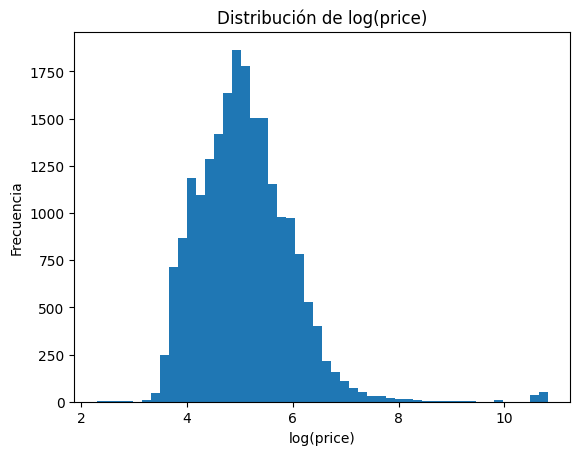

In [22]:
# Me quedo solo con registros que tengan precio positivo
df = df[df['price'] > 0].copy()

# Creo la variable objetivo en escala logarítmica
df['log_price'] = np.log(df['price'])

# Reviso cómo queda la distribución de log(price)
df['log_price'].describe()
plt.hist(df['log_price'], bins=50)
plt.title('Distribución de log(price)')
plt.xlabel('log(price)')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
# Tomo únicamente columnas numéricas (incluye dummies 0/1)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Saco price y log_price del set de features
numeric_cols.remove('price')
numeric_cols.remove('log_price')

X = df[numeric_cols].values
y = df['log_price'].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Número de features:", len(numeric_cols))


Shape X: (20827, 98)
Shape y: (20827,)
Número de features: 98


In [24]:
from sklearn.model_selection import train_test_split

# Dejo 20% de los datos para prueba final
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (16661, 98) (16661,)
Test : (4166, 98) (4166,)


In [25]:
import setuptools.dist  # necesario con Python 3.12
import tensorflow as tf

# Defino capa de normalización usando solo la info del train
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(X_train)

n_features = X_train.shape[1]
print("Cantidad de features que ve la red:", n_features)


Cantidad de features que ve la red: 98


In [26]:
# Primer intento: una sola capa oculta moderada, sin dropout
modelo_mlp_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_features,)),
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)   # salida para log(price)
])

modelo_mlp_1.summary()

# Compilo usando MSE sobre log(price) y reporto RMSE y MAE
modelo_mlp_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        tf.keras.metrics.MeanAbsoluteError(name='mae')
    ]
)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 98)             │           197 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 64)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,598 (25.78 KB)

 Trainable params: 6,401 (25.00 KB)

 Non-trainable params: 197 (792.00 B)

In [29]:
import time

inicio = time.time()

hist_1 = modelo_mlp_1.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=512,
    verbose=1
)

fin = time.time()
print(f"Tiempo de entrenamiento modelo 1: {fin - inicio:.2f} segundos")

hist_1_df = pd.DataFrame(hist_1.history)
hist_1_df['epoch'] = hist_1.epoch
hist_1_df.head()



Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 27.0180 - mae: 5.0076 - rmse: 5.1979 - val_loss: 18.9043 - val_mae: 4.2162 - val_rmse: 4.3479
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.3203 - mae: 3.6243 - rmse: 3.7842 - val_loss: 9.4483 - val_mae: 2.9329 - val_rmse: 3.0738
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8342 - mae: 2.4248 - rmse: 2.6142 - val_loss: 4.1016 - val_mae: 1.8380 - val_rmse: 2.0252
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9605 - mae: 1.4736 - rmse: 1.7206 - val_loss: 1.7363 - val_mae: 1.0881 - val_rmse: 1.3177
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4233 - mae: 0.9301 - rmse: 1.1930 - val_loss: 0.9875 - val_mae: 0.7692 - val_rmse: 0.9937
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9379 - mae: 0.7264 - rmse: 0.9684 - val_loss: 0.7751 - val_mae: 0.6666 - val_rmse: 0.8804
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7629 - mae: 0.6511 - rmse: 0.8734 - 

,loss,mae,rmse,val_loss,val_mae,val_rmse,epoch
0,27.017967,5.007567,5.197881,18.904278,4.216172,4.347905,0
1,14.320262,3.624310,3.784212,9.448315,2.932877,3.073811,1
2,6.834189,2.424770,2.614228,4.101623,1.837978,2.025246,2
3,2.960527,1.473588,1.720618,1.736313,1.088133,1.317692,3
4,1.423294,0.930118,1.193019,0.987466,0.769161,0.993713,4
